# PyTorch tutorial

This notebook serves as a hands-on ***tutorial*** designed for individuals who want to explore and better understand ***PyTorch***. In particular, we will focus on its application in ***computer vision***, demonstrating how to build and train models for image classification tasks.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset, random_split#, TensorDataset
from torch import optim

from torchvision import datasets
import torchvision.models as models
import torchvision.transforms as T

from model import Model_cnn, train_eval_model

**Most important points to explore :**

- Loading Data and Devices
- Autograd
- Optimizer
- Loss
- Model
- DataLoader
- Split
- Saving/Loading Weights
- Evaluation
- Visualization

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

# Importing dataset

In this notebook, we will use the **FashionMNIST** dataset available in the **torchvision** package. This dataset consists of grayscale images of Zalando’s fashion articles, such as shoes, shirts, and bags. It is commonly used as a benchmark for image classification tasks.

In [3]:
train_transform = T.Compose([
    T.ToTensor(),
    # T.Normalize(mean=[0.5], std=[0.5])
])

In [4]:
train = datasets.FashionMNIST(
    root="data", 
    train=True,
    download=True, 
    transform=train_transform, 
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=T.ToTensor()
)

In [5]:
# train_data, val_data = random_split(train, [len(train_idx), len(val_idx)])

# len_img=len(train)
# len_train=int(0.85*len_img)
# len_val=len_img-len_train
# len_test=len(test_data)

In [6]:
train_idx, val_idx = train_test_split(
    range(len(train)),
    test_size=0.1,
    stratify=[int(elt[1]) for elt in train],
    random_state=42
)


print(f'Training dataset size : {len(train_idx)}')
print(f'Validation dataset size : {len(val_idx)}')
print(f'Test dataset size : {len(test_data)}')

Training dataset size : 54000
Validation dataset size : 6000
Test dataset size : 10000


In [7]:
train_data = Subset(train, train_idx)
val_data = Subset(train, val_idx)

In [8]:
class_names = train_data.dataset.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

In [9]:
from collections import Counter

def class_distribution(subset, name):

    if hasattr(subset, "dataset") and hasattr(subset.dataset, "targets"):
        labels = [int(subset.dataset.targets[i]) for i in subset.indices]
    else:
        labels = [int(i) for i in subset.targets]

    counter = Counter(labels)       

    print(f'----------------------------\n{name}\n----------------------------')

    for i in np.unique(labels):
        count = counter[i]
        percentage = (count/len(labels))*100
        print(f'{class_names[i]} : {percentage:.2f} %')    

In [10]:
class_distribution(train_data, "Training dataset")

----------------------------
Training dataset
----------------------------
T-shirt/top : 10.00 %
Trouser : 10.00 %
Pullover : 10.00 %
Dress : 10.00 %
Coat : 10.00 %
Sandal : 10.00 %
Shirt : 10.00 %
Sneaker : 10.00 %
Bag : 10.00 %
Ankle boot : 10.00 %


In [11]:
class_distribution(val_data, "Validation dataset")

----------------------------
Validation dataset
----------------------------
T-shirt/top : 10.00 %
Trouser : 10.00 %
Pullover : 10.00 %
Dress : 10.00 %
Coat : 10.00 %
Sandal : 10.00 %
Shirt : 10.00 %
Sneaker : 10.00 %
Bag : 10.00 %
Ankle boot : 10.00 %


In [12]:
class_distribution(test_data, "Test dataset")

----------------------------
Test dataset
----------------------------
T-shirt/top : 10.00 %
Trouser : 10.00 %
Pullover : 10.00 %
Dress : 10.00 %
Coat : 10.00 %
Sandal : 10.00 %
Shirt : 10.00 %
Sneaker : 10.00 %
Bag : 10.00 %
Ankle boot : 10.00 %


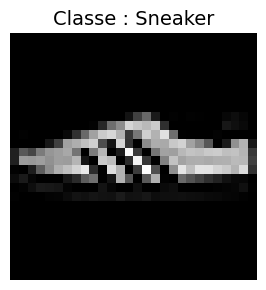

In [13]:
from PIL import Image

img_idx = torch.randint(0, len(train_data), (1,))[0]
img_tensor, label = train_data[img_idx]
to_pil = T.ToPILImage()
img = to_pil(img_tensor)
class_name = class_names[label]

plt.figure(figsize=(3,3))
plt.imshow(img, cmap="gray")
plt.title(f"Classe : {class_name}", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()


# Preparing the data

In deep learning, we typically use the **mini-batch gradient descent** algorithm.
Therefore, **DataLoaders** are designed to efficiently organize datasets into batches, making it easier to feed data to the model during training.

In [14]:
batch_size = 32

train_dataloader = DataLoader(train_data,
    batch_size=batch_size,
    shuffle=True
)

val_dataloader = DataLoader(val_data,
    batch_size=batch_size,
    shuffle=True
)

test_dataloader = DataLoader(test_data,
    batch_size=batch_size,
    shuffle=True
)

print(f"Length of train dataloader: {len(train_dataloader)} batches of {batch_size}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {batch_size}")

Length of train dataloader: 1688 batches of 32
Length of test dataloader: 313 batches of 32


# Modeling 

Convolutional Neural Networks (CNNs) are one of the fundamental architectures in computer vision. A typical CNN architecture is composed of ***two main parts***:

1. ***Convolutional layers*** – These layers are responsible for feature extraction.
They apply convolutional filters to the input image to detect patterns such as edges, textures, or more complex shapes in deeper layers.

2. ***Fully connected layers*** – These layers act as the “classifier” part of the network.
They take the high-level features extracted by the convolutional layers and use them to make predictions, such as identifying the class of an image.

<p align="center">
    <img src="pytorch_cnn_lenet.jpg" width="750">
</p>

In [15]:
from torchsummary import summary

model = Model_cnn(len(class_names)).to(device=device)
summary(model, input_size=(1, 28, 28), device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 25, 25]             544
         MaxPool2d-2           [-1, 32, 12, 12]               0
            Conv2d-3             [-1, 64, 9, 9]          32,832
         MaxPool2d-4             [-1, 64, 4, 4]               0
            Linear-5                  [-1, 300]         307,500
              ReLU-6                  [-1, 300]               0
           Dropout-7                  [-1, 300]               0
            Linear-8                   [-1, 10]           3,010
Total params: 343,886
Trainable params: 343,886
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.24
Params size (MB): 1.31
Estimated Total Size (MB): 1.56
----------------------------------------------------------------


In [16]:
len(val_dataloader.dataset)

6000

In [17]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
num_epochs = 15
model, train_losses, val_losses, train_accs, val_accs = train_eval_model(model, train_dataloader, val_dataloader, num_epochs, optimizer, loss_fn, device,   verbose = True)

----------------------------------
Epoch [1/15]
----------------------------------
train loss : 2.30, train acc : 0.22 % [0/1688]
train loss : 0.79, train acc : 0.75 % [200/1688]
train loss : 0.75, train acc : 0.72 % [400/1688]
train loss : 0.57, train acc : 0.84 % [600/1688]
train loss : 0.48, train acc : 0.78 % [800/1688]
train loss : 0.61, train acc : 0.84 % [1000/1688]
train loss : 0.51, train acc : 0.84 % [1200/1688]
train loss : 0.64, train acc : 0.75 % [1400/1688]
train loss : 0.79, train acc : 0.72 % [1600/1688]

Avg Train Loss: 0.74, Train Acc : 73.47 % | Avg Val Loss: 0.53 , Val Acc : 80.62 % 
----------------------------------
Epoch [2/15]
----------------------------------
train loss : 0.31, train acc : 0.91 % [0/1688]
train loss : 0.55, train acc : 0.75 % [200/1688]
train loss : 0.33, train acc : 0.88 % [400/1688]
train loss : 0.51, train acc : 0.81 % [600/1688]
train loss : 0.44, train acc : 0.84 % [800/1688]
train loss : 0.40, train acc : 0.84 % [1000/1688]
train loss : 

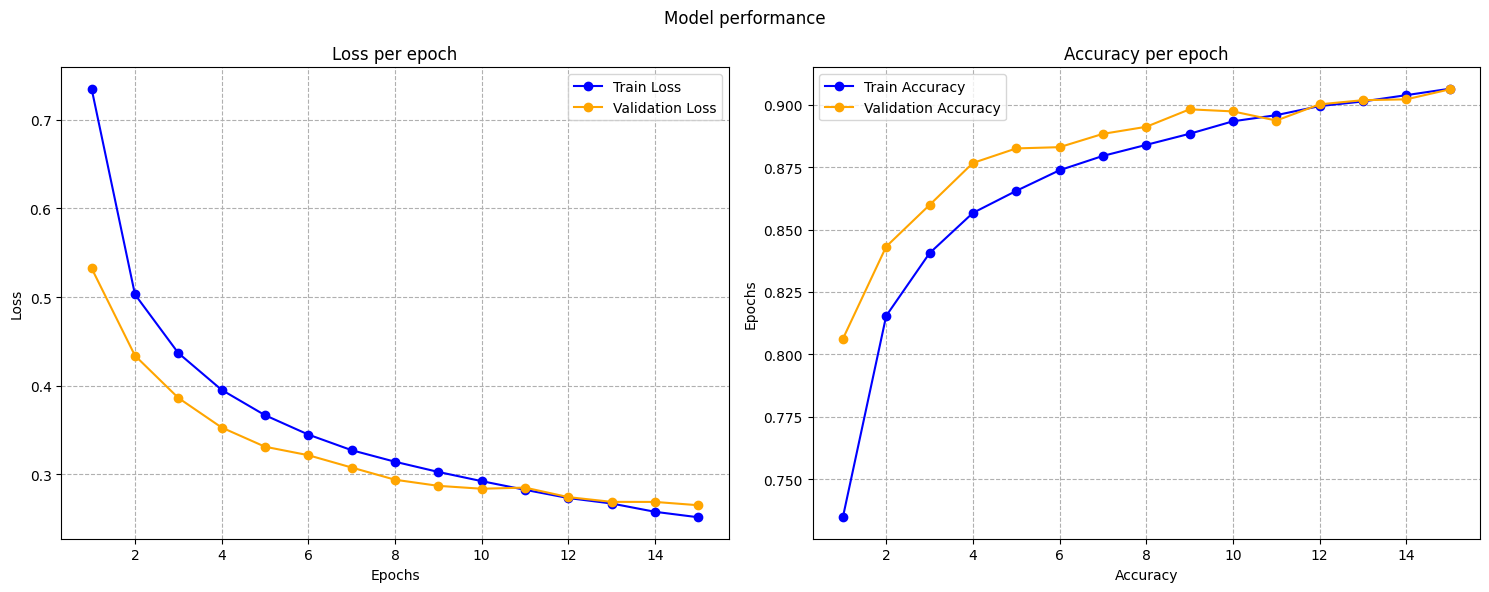

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))
fig.suptitle('Model performance')

# ====== First plot ======
ax1.plot((np.arange(num_epochs)+1), train_losses, label = 'Train Loss', marker = 'o', color = 'blue')
ax1.plot((np.arange(num_epochs)+1), val_losses, label = 'Validation Loss', marker = 'o', color = 'orange')
ax1.set(xlabel= 'Epochs', ylabel= 'Loss')
ax1.set_title('Loss per epoch')
ax1.legend()
ax1.grid(True, linestyle ='--')


# ====== Second plot ======
ax2.plot((np.arange(num_epochs)+1), train_accs, label = 'Train Accuracy', marker = 'o', color = 'blue')
ax2.plot((np.arange(num_epochs)+1), val_accs, label = 'Validation Accuracy', marker = 'o', color = 'orange')
ax2.set(xlabel= 'Accuracy', ylabel= 'Epochs')
ax2.set_title('Accuracy per epoch')
ax2.legend()
ax2.grid(True, linestyle ='--')

plt.tight_layout()
plt.show()